<a href="https://colab.research.google.com/github/mauriciodev/spatialgeodesy/blob/main/exercises/Ex5_troposphere.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Exercise 5 - Tropospheric delay

In this exercise we are going to download one Global Ionosphere Map from IGS (International GNSS Service) and plot the daily Vertical Total Electron Content on a given coordinate. We will also plot the Ionospheric delay computed with the Klobuchar model.

Please note the differences between the tropospheric and ionospheric effects on the equations bellow. Such as:
- The tropospheric delay keeps the same sign on both equations.
- The coordinate of the receiver is used instead of the ionospheric pierce point (IPP).
- The tropospheric delay is the same on any frequency, while the ionospheric delay is difference on each frequency.

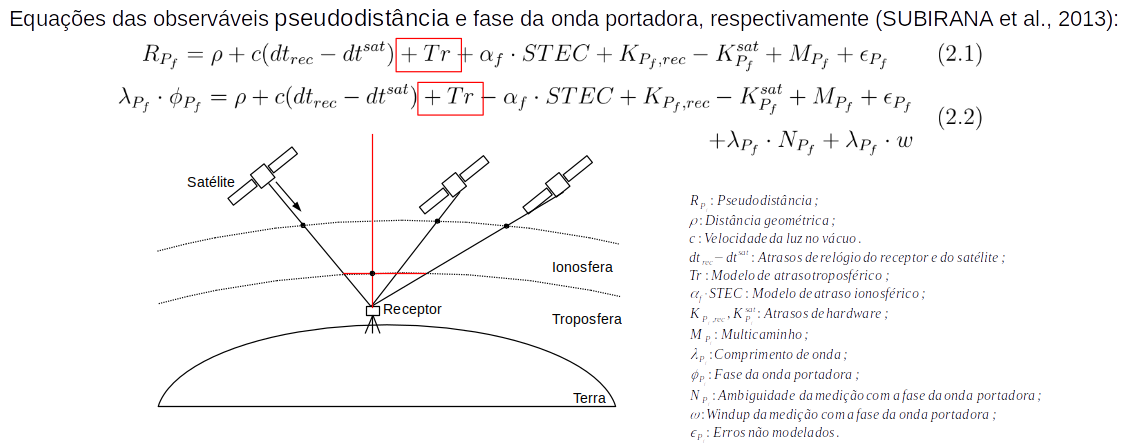

# Preparations

In [1]:
#Python standard libraries
import os #File path operations.
import shutil #Shell operations. Unzipping, moving files, etc.
import urllib.request #Downloader.
from urllib.parse import urlparse #url manipulation
import re #regular expressions to manipulate strings.
from datetime import datetime, timedelta

#External libraries
import numpy as np #Numeric Python.
import pandas as pd #Python Data Analysis Library.
import matplotlib.pyplot as plt #Plots.
import xarray as xa #Multi dimension arrays. For georinex.   

In [2]:
def download(url):
    print("Downloading from", url)
    fname=url.split("/")[-1] #get the last part of url, which is the file.
    urllib.request.urlretrieve(url,fname) #download the file saving as the name in obsRinexFile_v3
    return fname   

## SINEX reader

In [3]:
import re
import pandas as pd
from io import StringIO

"""Opens a sinex file and returns a dict of pandas dataframes containing the data on each sinex block."""
def read_sinex(fname):
    with open(fname) as f:
    #f = open(fname)
        data = f.read()   
        #sinex files declare blocks between +TAG and -TAG.
        blocks = re.findall(r'^\+(.*?)^-', data  , re.MULTILINE|re.DOTALL) 
        #tag=re.findall(r'^.+',blocks[0])[0]
        dictData = {}
        for block in blocks:
            tag = re.findall(r'^.+',block)[0]
            header=' '.join(re.findall(r'\n\*.+',block))
            header=re.sub('(\n\*)','',header).split()
            header=list(map(lambda x: x[1]+str(x[0]), enumerate(header)))
            #counting header size
            #widths=list(map(lambda x: len(x)+1, header))
            widths=list(map(len, header))
            lines=re.findall(r'\n\s.+',block, re.DOTALL)
            if len(lines)>0:
                df=pd.read_fwf(StringIO(lines[0].strip()), widths=widths, names=header, mangle_dupe_cols=True)
                dictData[tag] = df
            else:
                dictData[tag]=None
    return dictData

# Input parameters

In [4]:
#This is the reference time. We are going to use it to download the files.
#We are using 2020 again because IGN data is easier to download, but doesn't cover the recent years.
t = pd.to_datetime('2020-01-01 00:00:00') 
station="BRAZ" #This is the station. 

The coordinates of the BRAZ station were obtained at http://geoftp.ibge.gov.br/informacoes_sobre_posicionamento_geodesico/rbmc/relatorio/Descritivo_BRAZ.pdf

In [5]:
#inputs
lat = -(15 + 56/60 + 50.91123/3600) #- 15° 56' 50,91123"
lon = -(47 + 52/60 + 40.32834/3600) #- 47° 52' 40,32834"
h_ell = 1106.020 
E=60 #Elevation
print(lat, lon, h_ell, E)

-15.947475341666667 -47.877868983333336 1106.02 90


# Reading IGS Zenith Tropospheric Delay (ZPD) file
IGS's ZTD file are computed on the Zenith of each IGS station. They solve the Precise Point Positioning (PPP) for each station. Besides the position, the PPP also estimates the tropospheric delay.
 
We chose the BRAZ station, maintained by IBGE on the RBMC. 


In [6]:
url=f"ftp://igs.ign.fr/pub/igs/products/troposphere/{t.year:04}/{t.day_of_year:03}/{station.lower()}{t.day_of_year:03}0.{t.year%100}zpd.gz"
fname=download(url)
!uncompress $fname -f #uncompressing .Z file.
uncomp_fnamex= fname[:-3]
print(uncomp_fnamex)



braz0010.20zpd


In [7]:
sinex_dict=read_sinex(uncomp_fnamex)
print('\n'.join(sinex_dict.keys()))

SITE/ID
SITE/RECEIVER
SITE/ANTENNA
SITE/GPS_PHASE_CENTER
SITE/ECCENTRICITY
TROP/DESCRIPTION
TROP/STA_COORDINATES
TROP/SOLUTION


In [8]:
print(sinex_dict['TROP/SOLUTION'])

    SITE0 ____EPOCH___1  TROTOT2  STDDEV3  TGNTOT4  STDDEV5  TGETOT6  STDDEV7
0    BRAZ  20:001:00000   2260.8      2.6    2.031    0.426    -1.35  0  0.35
1    BRAZ  20:001:00300   2260.5      2.4    2.010  5  0.40  8  -1.3  62  0.3
2    BRAZ  20:001:00600   2260.0      2.3    2.000  0  0.40  2  -1.3  73  0.3
3    BRAZ  20:001:00900   2259.8      2.2    1.980  8  0.38  5  -1.4  23  0.3
4    BRAZ  20:001:01200   2260.5      2.2    1.970  7  0.38  1  -1.4  73  0.3
..    ...           ...      ...      ...      ...      ...      ...      ...
283  BRAZ  20:001:84900   2281.5      2.2    0.690  9  0.28  0  -0.5  41  0.3
284  BRAZ  20:001:85200   2282.6      2.3    0.660  3  0.29  5  -0.5  25  0.3
285  BRAZ  20:001:85500   2283.6      2.4    0.660  5  0.29  6  -0.5  23  0.3
286  BRAZ  20:001:85800   2285.1      2.5    0.660  7  0.31  4  -0.5  21  0.4
287  BRAZ  20:001:86100   2286.2      2.7    0.670  0  0.32  0  -0.5  14  0.4

[288 rows x 8 columns]


In [9]:
#The epoch is represented as year:doy:seconds_of_the_day, so we split using ":" and get the third column (index 2).
secondsOfTheDay=pd.to_numeric(sinex_dict['TROP/SOLUTION']['____EPOCH___1'].str.split(':', expand=True)[2])

Text(0, 0.5, 'Tropospheric delay (m)')

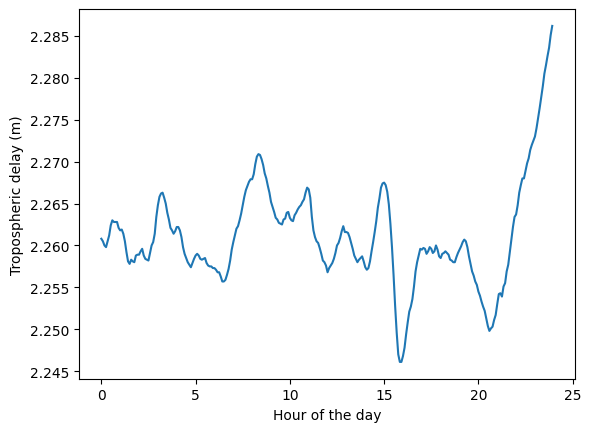

In [10]:
plt.plot(secondsOfTheDay/60./60.,sinex_dict['TROP/SOLUTION']['TROTOT2']/1000.)
plt.xlabel("Hour of the day")
plt.ylabel("Tropospheric delay (m)")

It can be noted that the total delay was between 2.245 and 2.285 m along the day, with some variations of centimeters.

# GPT3 - Global Pressure and Temperature 3
https://link.springer.com/article/10.1007/s00190-017-1066-2 \
GPT3 model can be used to compute the estimated pressure and temperature if you have no weather data available. The method returns many parameters, but p, T and e are of higher importance.
Output:

     p:    pressure in hPa (vector)
     T:    temperature in degrees Celsius (vector)
     dT:   temperature lapse rate in degrees per km (vector)
     Tm:   mean temperature weighted with the water vapor in degrees Kelvin (vector)
     e:    water vapour pressure in hPa (vector)
     ah:   hydrostatic mapping function coefficient (VMF3) (vector)
     aw:   wet mapping function coefficient (VMF3) (vector)
     la:   water vapour decrease factor (vector)
     undu: geoid undulation in m (vector)
     Gn_h: hydrostatic north gradient in m (vector)
     Ge_h: hydrostatic east gradient in m (vector)
     Gn_w: wet north gradient in m (vector)
     Ge_w: wet east gradient in m (vector)

The code is being downloaded from https://vmf.geo.tuwien.ac.at/codes/Python_Tools_Adavi/

In [11]:
gridFile=download("https://vmf.geo.tuwien.ac.at/codes/gpt3_5.grd")
download("https://vmf.geo.tuwien.ac.at/codes/Python_Tools_Adavi/gpt3_5_fast_readGrid.py")
download("https://vmf.geo.tuwien.ac.at/codes/Python_Tools_Adavi/gpt3_5_fast.py")

from gpt3_5_fast_readGrid import gpt3_5_fast_readGrid
from gpt3_5_fast import gpt3_5_fast
grid=gpt3_5_fast_readGrid(gridFile)

In [12]:
#Modified Julian date

def compute_p_T_e(timestamp, lat, lon, h_ell):
  mjd=timestamp.to_julian_date() - 2400000.5
  #Note that gpt3 computes maps if you provide lists of latitudes, longitudes and heights.
  gpt3_output=gpt3_5_fast(mjd, [np.radians(lat)], [np.radians(lon)], [h_ell], grid=grid)
  p=gpt3_output[0][0,0]
  T=gpt3_output[1][0,0]
  e=gpt3_output[4][0,0]
  return p, T, e # p, T, e #pressure, temperature, water vapor pressure


# Tropospheric delay computation

The tropospheric delay is computed in two components hydrostatic ($h$) and wet ($w$). While the hydrostatic is easier to compute, the wet component requires more information about the atmosphere.
\begin{equation}T_r^s=T_{zh}mh(E) + T_{zw}mw(E)$\end{equation}
Where: \
$T_{zh}$ is the zenithal hydrostatic delay component.\
$mh(E)$ is the mapping function for the hydrostatic component, that depends on the elevation E (in degrees).\
$T_{zw}$ is the zenithal wet delay component.\
$mw(E)$ is the mapping function for the wet component, that depends on the elevation E (in degrees).

# Saastamonien
This model is used on the GALILEO system, but we are using a simplification here. 
Be careful with the temperature (it is usually in Kelvin) and the coordinates should be in radians. 

\begin{gather}
T_{zh}=\frac{0.0022768\cdot P }{1.0-0.00266 \cdot cos(2 \cdot lat)-0.00028 \cdot h/1000} \\
T_{zw}=0.002277 \cdot \left(\frac{1255.0}{T}+0.05 \right) \cdot \bar e 
\end{gather}
Please not that $\bar e$ is the water vapour pressure, that was computed with GPT3. h is the height (in meters), $\phi$ is the latitude, T is the temperature, P is the surface pressure in hPa.  Adapted from RTKLIB https://github.com/tomojitakasu/RTKLIB/blob/master/src/rtkcmn.c

In [13]:
"""φ: Ellipsoidal latitude
h: Surface height above the ellipsoid in [m]
p: Total Surface pressure in [hPa]"""
def saastamoinen(p, h, lat, temp, e): #Inputs pressure, ellipsoidal height, lat, temperature, water vapour pressure
  #PLEASE FILL THIS PART OF THE CODE


  return (Tzh, Tzw);

In [14]:
p, temp, e = compute_p_T_e(t, lat, lon, h_ell)
saastamoinen(p, h_ell, lat, temp, e)

(2.030380782889252, 0.1836325657109107)

# Hopfield
Now you're going to write a code that computes the ZTD following Hopfield's formulae.
https://revistas.uepg.br/index.php/ret/article/view/11642/209209209617
\begin{gather}
H_d =  40136 + 148.72 \cdot (T - 273.16) \\
H_w = 11000\\
T_{zh}=155.2 \cdot 10^{-7} \cdot \frac{P}{T}\cdot H_d \\
T_{zw}= 155.2 \cdot 10^{-7} \cdot \frac{4810 \cdot \bar e}{T^2}\cdot H_w
\end{gather}


In [15]:
#Hopfield Model
def hopfield(p, T, e): #inputs: pressure, temperature, water vapor
  #PLEASE FILL THIS PART OF THE CODE


  return (Tzh, Tzw)

# Comparing both models on time t

In [16]:
p,temp, e = compute_p_T_e(t, lat, lon, h_ell)
print(hopfield(p, temp,e))
print(saastamoinen(p, h_ell, lat, temp, e))

(2.029927035175956, 0.17719414297459504)
(2.030380782889252, 0.1836325657109107)


# Let's plot the differences

In [17]:
timestamps=t+pd.to_timedelta(secondsOfTheDay/60./60., unit='H')

saastamoinen_data=[]
hopfield_data=[]
for timestamp in timestamps:
  p, temp, e =compute_p_T_e(timestamp, lat, lon, h_ell)
  hopfield_data.append(hopfield(p,temp,e))
  saastamoinen_data.append(saastamoinen(p, h_ell, lat, temp, e))
saastamoinen_data=np.array(saastamoinen_data).T
hopfield_data=np.array(hopfield_data).T

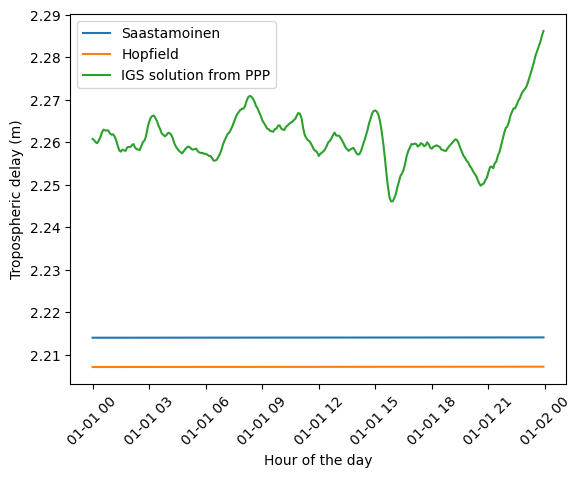

In [18]:
plt.plot(timestamps, saastamoinen_data[0]+saastamoinen_data[1], label='Saastamoinen')
plt.plot(timestamps, hopfield_data[0]+hopfield_data[1], label='Hopfield')
plt.plot(timestamps,sinex_dict['TROP/SOLUTION']['TROTOT2']/1000., label='IGS solution from PPP')
plt.legend()
plt.xticks(rotation = 45) # Rotates X-Axis Ticks by 45-degrees
plt.xlabel("Hour of the day")
plt.ylabel("Tropospheric delay (m)")
plt.show()

# Write your conclusions about the differences between the 3 models HERE

# Mapping functions
There are many mapping functions. Each model usually comes with it's mapping function. Since we were trying to compare the Zenith Delays using multiple methods, whe just computed everything on the Zenith. Bellow you see an example of a simple mapping function. Note that we gave E (elevation) to mapping function. This angle is computed with the line of sight between the satellite and the receiver and the local horizon.

\begin{gather}
mhE=1/np.sqrt(np.sin((E^2 + 6.25)))\\
mwE=1/np.sin((np.sqrt(E^2 + 2.25)))
\end{gather}

In [19]:
E=np.radians(60)

mhE=1/np.sqrt(np.sin((E**2 + 6.25)))
mwE=1/np.sin((np.sqrt(E**2 + 2.25)))
print("mw(E):",mwE, "mh(E):",mhE)
     


mw(E): 1.0343896161200608 mh(E): 1.0696375422008504


Note that the mapping functions increase the delay, because the path to the receiver throught the atmosphere is longer than on the zenith.

# Total trophospheric delay
Now compute the total tropospheric delay (using the mhE and mwE above) using both saastamoinen and hopfield at time t.

In [20]:
p,temp, e = compute_p_T_e(t, lat, lon, h_ell)
Tzh_hop, Tzw_hop =hopfield(p, temp,e)
Tzh_sas, Tzw_sas = saastamoinen(p, h_ell, lat, temp, e)

In [21]:
#PLEASE FILL THIS PART OF THE CODE




print("Hopfield ZTD:", ztd_hop)
print("Saastamoinen ZTD:", ztd_saas)

Hopfield ZTD: 2.3545739462828834
Saastamoinen ZTD: 2.361719129494349
